# Notebook 04 - Feature Engineering

## Objectives

* Engineer features for the regression modelling

## Inputs

* outputs/datasets/cleaned/v1/TrainSetCleaned.csv
* outputs/datasets/cleaned/v1/TestSetCleaned.csv

## Outputs

* Generate a list of variables to engineer

[## Additional Comments / Conclusions]


---

# Import Packages

In [9]:
import os
import pandas as pd
from ydata_profiling import ProfileReport
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [1]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor\\jupyter_notebooks'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor'

---

# Load Cleaned Data

Train Set

In [5]:
train_set_path = "outputs/datasets/cleaned/v1/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0.0,3.0,Av,48,Missing,1774,774,Unf,2007.0,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
1,894,0.0,2.0,No,0,Unf,894,308,Unf,1962.0,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
2,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500
3,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,13265,69.0,148.0,59,5,8,1568,2002,2002,271000
4,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


Test Set

In [6]:
test_set_path = "outputs/datasets/cleaned/v1/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,2515,0.0,4.0,No,1219,Rec,816,484,Unf,1975.0,...,32668,70.0,0.0,0,3,6,2035,1957,1975,200624
1,958,620.0,3.0,No,403,BLQ,238,240,Unf,1941.0,...,9490,79.0,0.0,0,7,6,806,1941,1950,133000
2,979,224.0,3.0,No,185,LwQ,524,352,Unf,1950.0,...,7015,70.0,161.0,0,4,5,709,1950,1950,110000
3,1156,866.0,4.0,No,392,BLQ,768,505,Fin,1977.0,...,10005,83.0,299.0,117,5,7,1160,1977,1977,192000
4,525,0.0,3.0,No,0,Unf,525,264,Unf,1971.0,...,1680,21.0,381.0,0,5,6,525,1971,1971,88000


---

# Data Exploration

We create a Pandas profiling report to evaluate what transformations may be of help in adjusting the variables so that the algorithm can better use them:

In [8]:
profile = ProfileReport(df=TrainSet, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We note that:
* There are several categorical variables, which we will transform to numerical.
* For the existing numerical variables, we can investigate whether transformations might improve their distribution such that the algorithm can better handle the data.
* When we have finished any other transformations, we should perform smart correlated feature selection so that only the most informative features are retained and redundancy is minimised.
    - This helps to improve model performance and reduce overfitting by choosing a subset of those features that are most relevant to the target variable and have little or no multicollinearity among themselves.

---

# Feature Engineering

## Custom Function

The following custom function is copied and adapted from Code Institute's Walkthrough Project 2 on customer churn.
* This function performs feature engineering on numerical and categorical variables.
    - In particular, for each numerical variable, it applies a series of transformations to yield different distributions of that variable, in the hope that we might find one that the model can handle better than the original
* Together with a reporting tool such as Pandas profiling, this helps to inform us which transformations might be most appropriate for each variable to make it more suited to ingestion by the algorithm

In [14]:
def feature_engineering_analysis(df, analysis_type=None):
    """
    Performs quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    Once transformed, we use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # Create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Feature Engineering: Summary of Steps

The transformers that we apply will be as follows:

* Categorical Encoding
* Numerical Transformation
* Smart Correlation Selection

---

# Feature Engineering: Detailed Steps

## Ordinal Categorical Encoding

The following variables are categorical and will be ordinally encoded:

In [12]:
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

We create a separate dataframe with these variables:

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,Av,Missing,Unf,Gd
1,No,Unf,Unf,TA
2,No,ALQ,Unf,TA
3,No,GLQ,RFn,Gd
4,No,Unf,RFn,Gd


We can then apply the `feature_engineering_analysis` function to transform the variables:

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



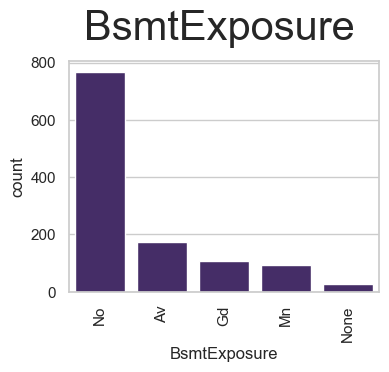

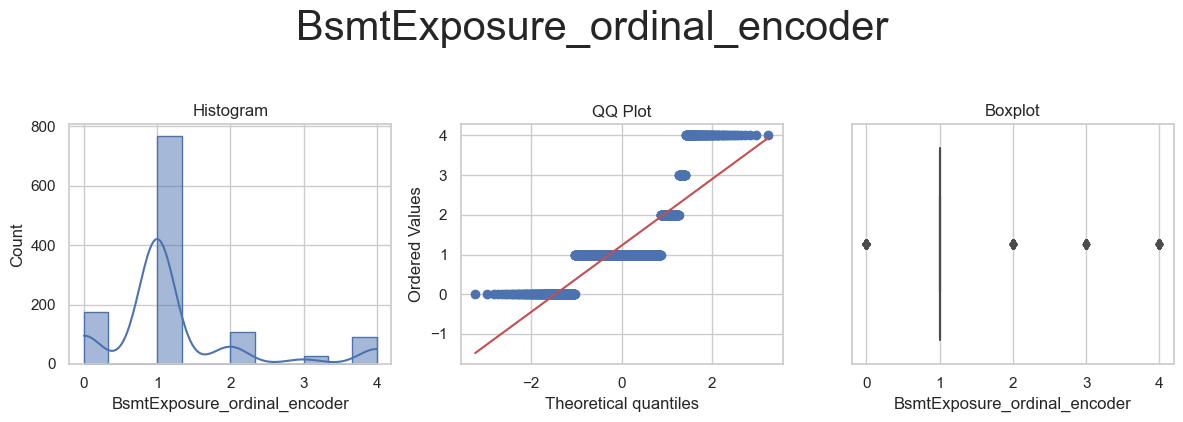



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



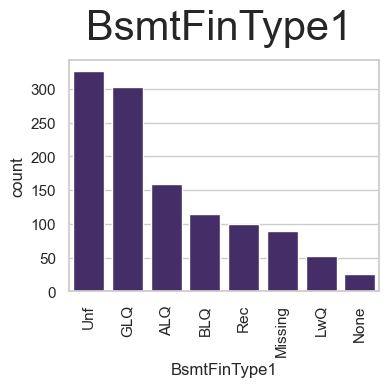

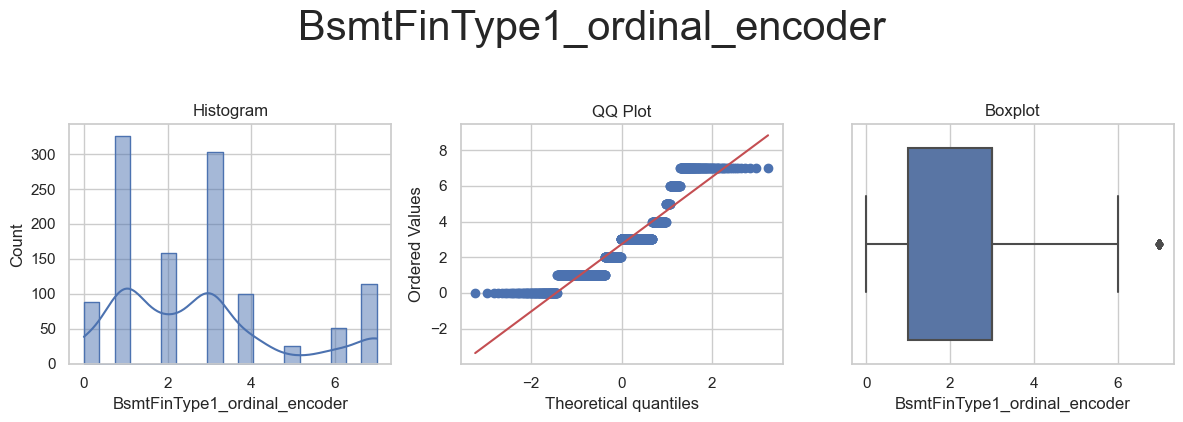



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



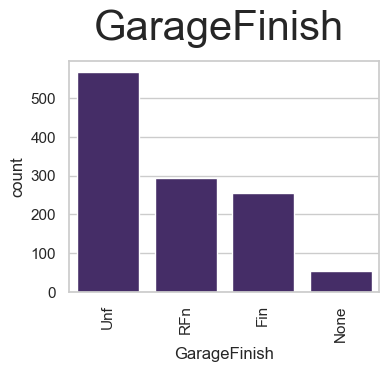

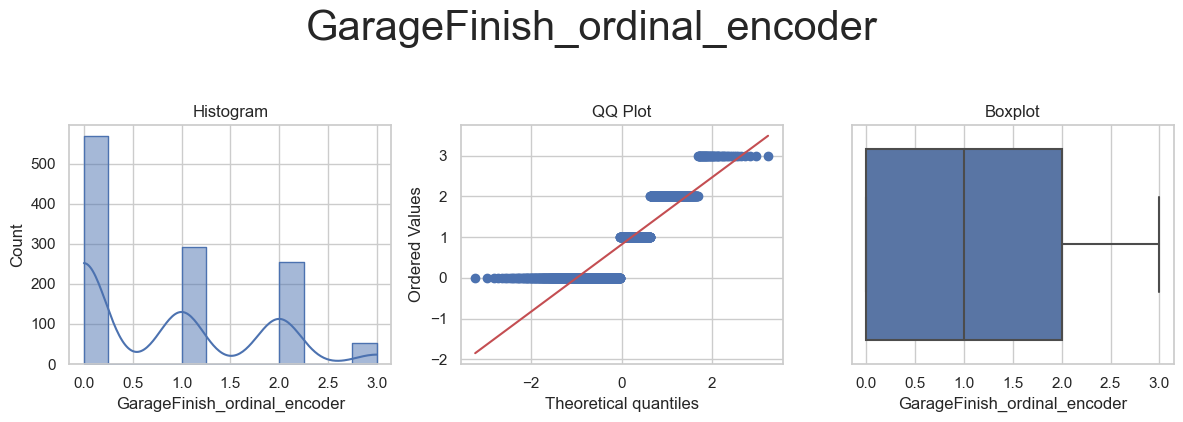



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



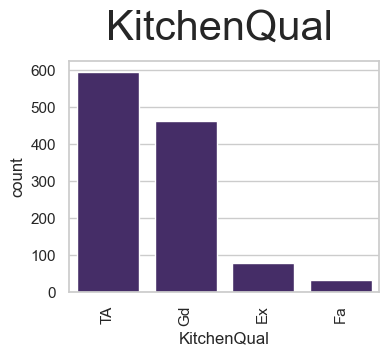

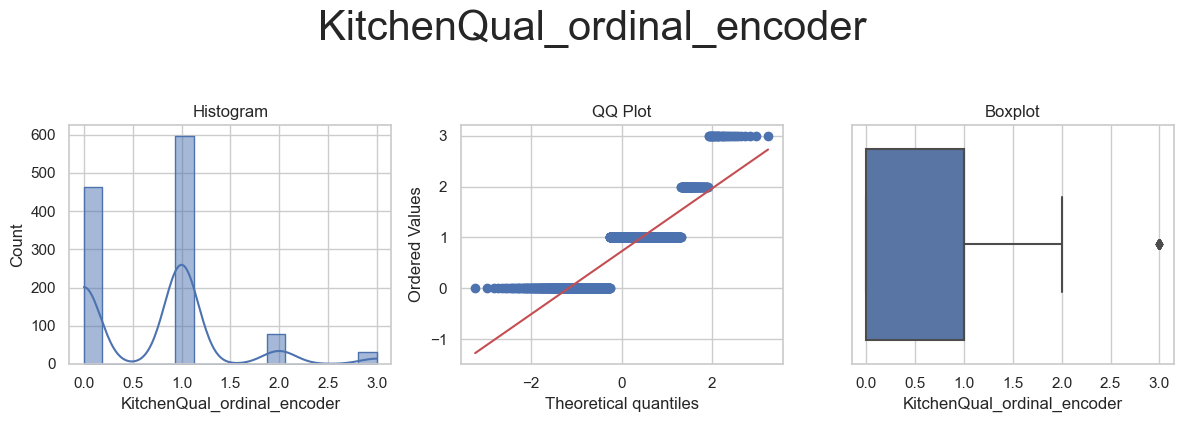

In [15]:
df_engineering = feature_engineering_analysis(df=df_engineering, analysis_type='ordinal_encoder')

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
